In [140]:
from pylab import *
import os
import sys
from sklearn.mixture import GaussianMixture
import pickle
from PIL import Image
import transforms3d

In [161]:
dataset_dir = 'rgbd_dataset_freiburg3_long_office_household'
gmm_dir = 'gmm_qqvga_mine_patch'
full_gmm_dir = os.path.join(dataset_dir,gmm_dir)

In [162]:
files = []
names = []
for fl in sorted(os.listdir(full_gmm_dir)):
    name,ext = os.path.splitext(fl)

    with open(os.path.join(full_gmm_dir,fl),'rb') as fp:
        clf = pickle.load(fp)
        files.append(clf)
    names.append(name)
initial_state_str = '-0.6832 2.6909 1.7373 0.0003 0.8617 -0.5072 -0.0145'
initial_state = np.array([float(_) for _ in initial_state_str.split(' ')])


In [163]:
import scipy.optimize as opt
#len(files)-1
results_trans = []
ttimes = 0.0
for i in range(len(files)-1):
    from_fl = files[i]
    to_fl = files[i+1] #i+1

    from_params = from_fl._get_parameters()
    to_params = to_fl._get_parameters()

    def loss_gmm_to_gmm(x):
        qs = x[:4]
        ts = x[4:]
        qs = qs/np.linalg.norm(qs)
        Ms = transforms3d.quaternions.quat2mat(qs)
        
        y = from_params[1] - (Ms @ to_params[1].T).T - ts
        sigma = from_params[2] + Ms @ to_params[2] @ Ms.T
        inv_sigma = np.array([np.linalg.inv(s) for s in sigma])
        dist = y[:,None,:] @ inv_sigma @ y[:,:,None]
        f = np.sqrt(np.linalg.det(inv_sigma))* from_params[0] * to_params[0] * np.exp(-0.5 * dist)
        return -f.sum()
    def loss_gmm_to_gmm2(x):
        qs = x[:4]
        ts = x[4:]
        qs = qs/np.linalg.norm(qs)
        Ms = transforms3d.quaternions.quat2mat(qs)
        
        a = from_params[1] - ts
        b = (Ms @ to_params[1].T).T
        #y2 = np.repeat(a,b.shape[0],0)-np.tile(b,(a.shape[0],1))
        #y2 = y2.sum(1).reshape((a.shape[0],a.shape[0]))
        y = a - b[:, None]

        sigma = from_params[2] + Ms @ to_params[2] @ Ms.T
        inv_sigma = np.array([np.linalg.inv(s) for s in sigma])
        dist = y.T @ inv_sigma @ y
        print(dist.shape)
        f = np.sqrt(np.linalg.det(inv_sigma))* from_params[0] * to_params[0] * np.exp(-0.5 * dist)
        return -f.sum()
    def loss_gmm_to_gmm_raw(x):
        qs = x[:4]
        ts = x[4:]
        qs = qs/np.linalg.norm(qs)
        Ms = transforms3d.quaternions.quat2mat(qs)
        total = 0
        for i in range(100):
            for j in range(100):
                y = from_params[1][i:i+1].T - (Ms @ to_params[1][j:j+1].T) - ts[:,None]
                sigma = from_params[2][i] + Ms @ to_params[2][j] @ Ms.T
                inv_sigma = np.linalg.pinv(sigma)
                dist = y.T @ inv_sigma @ y
                dist = dist.sum()
                f = np.sqrt(np.linalg.det(inv_sigma))* from_params[0][i] * to_params[0][j] * np.exp(-0.5 * dist)
                total += f

        return -total
    def loss_gmm_to_gmm_raw2(x):
        qs = x[:4]
        ts = x[4:]
        qs = qs/np.linalg.norm(qs)
        Ms = transforms3d.quaternions.quat2mat(qs)
        total = 0
        for i in range(100):
            y = from_params[1][i:i+1].T - (Ms @ to_params[1].T) - ts[:,None]
            y = y.T
            sigma = from_params[2][i].T + Ms @ to_params[2] @ Ms.T
            inv_sigma = np.linalg.inv(sigma)
            dist = np.squeeze(y[:,None,:] @ inv_sigma @ y[:,:,None])
            f = np.sqrt(np.linalg.det(inv_sigma))* from_params[0][i] * to_params[0] * np.exp(-0.5 * dist)
            total += f.sum()

        return -total
    def loss_gmm_to_gmm_raw3(x):
        qs = x[:4]
        ts = x[4:]
        qs = qs/np.linalg.norm(qs)
        Ms = transforms3d.quaternions.quat2mat(qs)
        total = 0
        a = from_params[1] - ts
        b = (Ms @ to_params[1].T).T
        y = a - b[:, None]
        y = y.reshape((-1,3))

        sigma = from_params[2] + (Ms @ to_params[2] @ Ms.T)[:,None]
        sigma = sigma.reshape((-1,3,3))
        inv_sigma = np.linalg.inv(sigma)

        dist = np.squeeze(y[:,None,:] @ inv_sigma @ y[:,:,None])
        dist = dist.reshape((a.shape[0],b.shape[0]))
        scaler = 1#np.sqrt(np.linalg.det(inv_sigma)).reshape((a.shape[0],b.shape[0]))
        f = scaler * from_params[0][None,:] * to_params[0][:,None] * np.exp(-0.5 * dist)
        total += f.sum()
        return -total
    #print(loss_gmm_to_gmm(np.array([1,0,0,0,0,0,0])))
    #print(loss_gmm_to_gmm_raw(np.array([1,0,0,0,0,0,0])))
    #print(loss_gmm_to_gmm_raw2(np.array([1,0,0,0,0,0,0])))

    #print(loss_gmm_to_gmm2(np.array([1,0,0,0,0,0,0])))
    cg_cnt = 0
    t1 = time.time()
    res = opt.minimize(loss_gmm_to_gmm_raw3,np.array([1,0,0,0,0,0,0]),method=None)
    #res2 = opt.minimize(loss_gmm_to_gmm_raw3,np.array([1,0,0,0,0,0,0]),method='CG')
    t2 = time.time()
    print(i,t2-t1,ttimes/(i+1))
    #raise
    ttimes += (t2 - t1)
    x = res.x
    qe = x[:4]
    qe = qe/np.linalg.norm(qe)
    te = x[4:]
    qe,te
    results_trans.append((te,qe))
    res.fun
print('total_time',ttimes)

0 0.2709681987762451 0.0
1 0.4321010112762451 0.13548409938812256
2 0.4046902656555176 0.23435640335083008
3 0.45772790908813477 0.27693986892700195
4 0.37459397315979004 0.3130974769592285
5 0.3677191734313965 0.32334689299265545
6 0.36019277572631836 0.3296857901981899
7 0.36153101921081543 0.33349916338920593
8 0.33900904655456543 0.33661381403605145
9 0.3735480308532715 0.33685333728790284
10 0.38622283935546875 0.34018921852111816
11 0.35984325408935547 0.3440253535906474
12 0.36373209953308105 0.34524211516747105
13 0.3798041343688965 0.3465628283364432
14 0.3621938228607178 0.34877891540527345
15 0.4469749927520752 0.3496173471212387
16 0.29372596740722656 0.3553442674524644
17 0.32819390296936035 0.3519210285610623
18 0.372722864151001 0.3506722324772885
19 0.35195112228393555 0.35177476406097413
20 0.34612607955932617 0.3517831620715913
21 0.4024519920349121 0.35152602195739746
22 0.33109331130981445 0.3537401945694633
23 0.3516428470611572 0.3527965744336446
24 0.414033889770

196 0.6628968715667725 0.5417145545107459
197 0.7028069496154785 0.5423265864150693
198 0.687453031539917 0.543133020401001
199 0.6415281295776367 0.5438546204566955
200 0.6589686870574951 0.5443405583130186
201 0.814382791519165 0.5449080242969022
202 0.6942999362945557 0.546235486204401
203 0.6371378898620605 0.546961292332294
204 0.8468227386474609 0.5474011781739025
205 0.6250121593475342 0.548854680894648
206 0.7304549217224121 0.549222591418575
207 0.6671180725097656 0.5500939006988819
208 0.7199699878692627 0.5506538249659196
209 0.7230801582336426 0.5514600924083165
210 0.7075791358947754 0.5522734576491948
211 0.8505949974060059 0.5530060316031834
212 1.9044129848480225 0.5544031628980323
213 0.5852699279785156 0.5607116200099481
214 0.8497138023376465 0.5608258446981741
215 0.7851059436798096 0.5621632889465049
216 0.8081741333007812 0.5631906744521884
217 0.7061870098114014 0.5643144517863562
218 0.6321978569030762 0.564962271686014
219 1.1021103858947754 0.5652678879824552


392 0.8280520439147949 0.6156478462025106
393 0.5554580688476562 0.616186943151019
394 0.5502381324768066 0.6160331991654409
395 0.7590038776397705 0.6158670500071362
396 0.8556520938873291 0.6162275961724577
397 3.1931040287017822 0.6168291652621936
398 1.754868984222412 0.6232859944938717
399 2.651998996734619 0.626114951968193
400 2.1241519451141357 0.6311670318803287
401 0.5648441314697266 0.6348809246993183
402 0.6164288520812988 0.6347071361305104
403 0.7625768184661865 0.6346618928531609
404 0.5379152297973633 0.6349777321756622
405 0.5924739837646484 0.63473866197276
406 0.5940489768981934 0.6346348175545582
407 0.5650219917297363 0.6345353424549103
408 0.5887570381164551 0.6343653831621837
409 0.5619997978210449 0.6342541432962185
410 0.5792100429534912 0.6340783419690283
411 0.5477311611175537 0.6339451664859809
412 0.5668423175811768 0.6337364158676554
413 0.5802040100097656 0.6335748359201036
414 0.5409259796142578 0.6334462315203195
415 0.5255248546600342 0.633223827068622

589 0.7006089687347412 0.6462047249583874
590 0.5099680423736572 0.6462967795163846
591 0.6537981033325195 0.6460664944874274
592 0.7437381744384766 0.6460795326136417
593 0.7608072757720947 0.6462439411015622
594 0.7288169860839844 0.6464364845211766
595 0.7576858997344971 0.646574706839235
596 0.7355680465698242 0.6467608227402322
597 0.9904170036315918 0.6469093298034924
598 0.6849818229675293 0.6474827983741569
599 0.9591290950775146 0.6475452967484792
600 0.7455270290374756 0.648063739008594
601 0.6805849075317383 0.648225638161466
602 0.7242770195007324 0.6482793019580999
603 0.6718001365661621 0.6484051259937665
604 1.5792319774627686 0.6484437954327291
605 0.7864482402801514 0.6499797495284884
606 0.7791838645935059 0.6502045740602044
607 0.6202149391174316 0.6504167110512131
608 0.7142109870910645 0.650367118650665
609 0.5518531799316406 0.6504717807300755
610 0.5976357460021973 0.6503103754914529
611 0.6472299098968506 0.6502243058354247
612 0.606593132019043 0.65021942101333

786 0.7724058628082275 0.6758648513081416
787 0.776378870010376 0.6759873652821264
788 0.6209759712219238 0.6761146041981319
789 1.2808518409729004 0.6760448084601873
790 1.157228946685791 0.6768094191207596
791 0.883141040802002 0.6774160094333418
792 1.0352439880371094 0.6776754357024068
793 1.1935110092163086 0.6781257739295287
794 1.451418161392212 0.6787740572443548
795 1.320314884185791 0.6797447156666512
796 1.8346002101898193 0.6805484423523716
797 1.6505100727081299 0.6819946225125688
798 0.8477919101715088 0.6832067820247034
799 0.779116153717041 0.683412513434887
800 0.6284043788909912 0.6835319936349895
801 2.2869739532470703 0.6834632559607451
802 0.5891199111938477 0.6854601559573656
803 0.5377938747406006 0.6853403297822867
804 0.634303092956543 0.6851570422604958
805 0.5753068923950195 0.6850939480305901
806 0.8018970489501953 0.6849579045911408
807 2.605048894882202 0.6851026312549515
808 1.8614990711212158 0.6874758652025749
809 0.6212348937988281 0.6889252765679065
8

983 0.6060140132904053 0.7040583551899204
984 0.5970680713653564 0.7039588177869768
985 0.6520700454711914 0.7038504093220461
986 0.6957917213439941 0.7037979469473239
987 0.7260007858276367 0.703789843480114
988 0.7290451526641846 0.703812301460243
989 2.569916248321533 0.7038377891887319
990 0.7782306671142578 0.7057208148790777
991 0.7199161052703857 0.7057939094881858
992 0.9485108852386475 0.7058081312362041
993 0.6897637844085693 0.7060522989967699
994 1.9737107753753662 0.7060359286303496
995 0.7147650718688965 0.7073086945407362
996 1.086230993270874 0.7073161733545057
997 0.6487259864807129 0.7076958475227585
998 0.6629130840301514 0.7076368186328266
999 0.6666607856750488 0.7075920948982238
1000 0.6043739318847656 0.7075512044794195
1001 0.6349320411682129 0.7074482331494847
1002 0.6664283275604248 0.7073759338553858
1003 0.6610918045043945 0.7073351493869645
1004 0.5813417434692383 0.7072891361084743
1005 0.644507884979248 0.7071639398931272
1006 0.8101980686187744 0.7071017

1175 0.6378419399261475 0.6911891147392948
1176 0.5166671276092529 0.6911437900368197
1177 0.5905148983001709 0.6909956774201579
1178 0.531203031539917 0.6909104519925753
1179 0.5740280151367188 0.6907751067210052
1180 0.46477699279785156 0.6906762522827459
1181 0.48555588722229004 0.6904851361579701
1182 0.628791093826294 0.6903119077142376
1183 0.5583453178405762 0.6902599475673727
1184 0.4353771209716797 0.690148627204734
1185 0.5042147636413574 0.6899338114321936
1186 0.3867158889770508 0.689777350566321
1187 0.5443499088287354 0.6895222483259259
1188 2.108625888824463 0.6894001521615044
1189 0.4413180351257324 0.690592778830969
1190 0.5275580883026123 0.6903834801376817
1191 0.5088069438934326 0.6902468816545986
1192 0.5806739330291748 0.69009479453158
1193 0.780113935470581 0.6900031522690152
1194 0.6201930046081543 0.6900785587821545
1195 0.5931079387664795 0.6900201260445509
1196 0.5067520141601562 0.6899391634820796
1197 0.5821309089660645 0.6897862526729628
1198 0.64356398582

1367 0.5711150169372559 0.6859275212413386
1368 0.5748658180236816 0.6858436552776395
1369 0.5508308410644531 0.6857626495570162
1370 2.1747772693634033 0.6856642310241988
1371 0.5634829998016357 0.686749590381589
1372 0.547637939453125 0.6866598113644149
1373 0.7189018726348877 0.6865586309627327
1374 0.7966880798339844 0.6865821533203125
1375 0.5744180679321289 0.6866621721622556
1376 0.6853139400482178 0.6865806586515583
1377 0.639585018157959 0.6865797394072889
1378 0.6419332027435303 0.6865456605666439
1379 0.6197710037231445 0.6865133326986562
1380 0.5978338718414307 0.6864650037131561
1381 0.5943222045898438 0.686400871200948
1382 0.6042540073394775 0.686334292266305
1383 0.6338860988616943 0.6862749857020516
1384 0.5861878395080566 0.6862371597909755
1385 0.6748700141906738 0.6861649741342057
1386 0.6555678844451904 0.6861568306879595
1387 1.5923287868499756 0.6861347925422514
1388 0.5598049163818359 0.6867872000255544
1389 0.6699910163879395 0.6866958458646596
1390 0.600480079

1559 0.5917019844055176 0.6894716511934231
1560 0.5922229290008545 0.6894090184792733
1561 2.724203586578369 0.6893467994719248
1562 0.5268838405609131 0.6906486912103166
1563 0.44904398918151855 0.6905439822265255
1564 0.5229907035827637 0.690389669131928
1565 1.2477750778198242 0.6902827732407727
1566 1.815087080001831 0.69063854369679
1567 1.5514717102050781 0.6913556664878008
1568 1.3375520706176758 0.6919038602696475
1569 0.5120739936828613 0.6923151011679582
1570 0.5411758422851562 0.6922003709913287
1571 0.4312429428100586 0.6921042994081822
1572 0.5955917835235596 0.6919384625635553
1573 0.4967458248138428 0.6918772512045719
1574 0.4881737232208252 0.6917533582354349
1575 0.4496431350708008 0.691624183340121
1576 0.48049092292785645 0.6914707394287264
1577 0.5060710906982422 0.6913370386578134
1578 1.9395370483398438 0.6912197074684786
1579 0.500216007232666 0.6920097817348528
1580 1.7332029342651367 0.6918884700495257
1581 0.4489908218383789 0.6925466966387896
1582 0.493165016

1750 0.5036020278930664 0.68361139066011
1751 0.5045821666717529 0.6835086455900375
1752 0.48841428756713867 0.6834065768627595
1753 0.4608771800994873 0.6832954068004473
1754 0.49179697036743164 0.6831686727681391
1755 0.6380128860473633 0.6830596911608494
1756 0.6056842803955078 0.6830340526832663
1757 0.6185290813446045 0.6829900539504519
1758 1.931840181350708 0.6829534075760313
1759 0.5719358921051025 0.6836630023338578
1760 0.4275507926940918 0.6835995570696733
1761 0.5273783206939697 0.6834542399502774
1762 0.659113883972168 0.6833657113517203
1763 0.6307682991027832 0.6833519631502579
1764 0.6898519992828369 0.6833221707060384
1765 0.5817499160766602 0.6833258682307138
1766 1.6062531471252441 0.6832683832549618
1767 0.4700429439544678 0.6837904334607707
1768 0.46182918548583984 0.6836696039019768
1769 0.54298996925354 0.6835442703322502
1770 0.5173730850219727 0.6834649059612289
1771 0.513969898223877 0.6833711746853038
1772 0.477053165435791 0.6832756296901197
1773 0.517118215

1942 1.7629618644714355 0.7117606805761144
1943 0.5221681594848633 0.7123014219258548
1944 0.43450212478637695 0.7122036670351396
1945 0.5863549709320068 0.7120609632621444
1946 0.5234391689300537 0.7119963993215537
1947 0.5081322193145752 0.7118996040287449
1948 0.5177459716796875 0.7117950543187838
1949 0.5314600467681885 0.7116955419687124
1950 0.500173807144165 0.7116031608845502
1951 0.6376242637634277 0.7114948466664455
1952 0.6678709983825684 0.711457022507253
1953 0.5748462677001953 0.7114347164560121
1954 0.6550579071044922 0.7113648502418147
1955 0.5527799129486084 0.7113360634610697
1956 0.4977540969848633 0.711255043455698
1957 1.6553220748901367 0.7111460031357435
1958 0.5836021900177002 0.7116279715235712
1959 1.6817688941955566 0.7115626522472926
1960 0.615685224533081 0.7120574030081026
1961 0.6067330837249756 0.7120082836510817
1962 0.6422939300537109 0.7119546539007372
1963 0.6254220008850098 0.7119191851004079
1964 0.6554098129272461 0.711875166177143
1965 0.81931805

2134 0.5632941722869873 0.7104690416635339
2135 0.5518791675567627 0.7104001395711291
2136 0.6625187397003174 0.7103259603610148
2137 0.5302650928497314 0.7103035996404065
2138 0.5919480323791504 0.710219430165516
2139 0.5752880573272705 0.7101641631572047
2140 0.6108160018920898 0.7101011663772747
2141 0.7504682540893555 0.710054814759868
2142 0.5797042846679688 0.7100736731076652
2143 0.5836460590362549 0.7100128664899228
2144 0.5073432922363281 0.7099539542253757
2145 0.5774400234222412 0.7098595410557629
2146 0.580352783203125 0.7097978645221655
2147 0.8840219974517822 0.7097376014489257
2148 0.7163980007171631 0.709818701679732
2149 0.5316243171691895 0.7098217618188193
2150 0.5532619953155518 0.7097389178185173
2151 0.6429178714752197 0.7096662054939341
2152 0.7164499759674072 0.7096352030164521
2153 0.5722582340240479 0.7096383667921954
2154 0.7717599868774414 0.7095746173106324
2155 0.5075299739837646 0.7096034602464241
2156 2.0901949405670166 0.7095097775916894
2157 0.95991778

2325 2.253502130508423 0.7033737365889938
2326 0.48085784912109375 0.7040398854475755
2327 0.5315628051757812 0.7039440168752703
2328 0.9409520626068115 0.7038700017564642
2329 0.6690430641174316 0.7039717537139106
2330 0.6461219787597656 0.7039567692910894
2331 0.630824089050293 0.70393196878057
2332 0.7015380859375 0.703900632355482
2333 1.0741677284240723 0.7038996201247972
2334 0.8109462261199951 0.70405819319045
2335 0.8278379440307617 0.7041039500538617
2336 1.001344919204712 0.7041568957081094
2337 0.8893461227416992 0.7042840077797504
2338 1.2006568908691406 0.704363127965711
2339 0.8627078533172607 0.7045752193173792
2340 0.4491910934448242 0.7046427684989255
2341 0.5194859504699707 0.7045336943421987
2342 0.5368340015411377 0.7044547153648738
2343 0.5030310153961182 0.7043832048214337
2344 0.5809149742126465 0.7042973403483311
2345 0.5624439716339111 0.7042447476943944
2346 2.2623579502105713 0.704184329809409
2347 0.5660560131072998 0.7048479471945884
2348 0.6064169406890869

In [164]:

print(loss_gmm_to_gmm_raw(np.array([1,0,0,0,0,0,0])))
print(loss_gmm_to_gmm_raw3(np.array([1,0,0,0,0,0,0])))


-155.14715737108966
-0.0204120460037675


In [165]:
results_trans

[(array([-0.00073838,  0.00300584,  0.00070227]),
  array([ 9.99999658e-01,  8.17560988e-04, -1.14317233e-04,  5.13816822e-05])),
 (array([-5.00026432e-04, -2.58628643e-05, -2.50352750e-04]),
  array([ 9.99999558e-01, -5.93179238e-04,  2.65931853e-04, -6.79596759e-04])),
 (array([-0.00019403, -0.00208636, -0.00126805]),
  array([ 9.99999759e-01, -1.30074029e-04, -5.46235322e-05, -6.79470974e-04])),
 (array([-0.00433648,  0.00103391, -0.00011283]),
  array([ 9.99999191e-01,  1.11819264e-03,  2.96893942e-04, -5.28445025e-04])),
 (array([0.00198422, 0.00159674, 0.0001516 ]),
  array([ 9.99999816e-01,  3.18758050e-04, -1.55542026e-04, -4.92519920e-04])),
 (array([-0.00528864, -0.00241666, -0.0009108 ]),
  array([ 9.99999529e-01, -3.06863665e-04,  9.13434799e-04, -1.18367888e-04])),
 (array([1.71260449e-03, 2.10337139e-03, 6.07539540e-05]),
  array([ 9.99999539e-01,  7.52450709e-04, -2.06870171e-04, -5.58619406e-04])),
 (array([-0.00243489,  0.00246066,  0.00021329]),
  array([ 9.99999837e-

In [166]:
import pickle
with open('patch2_nodet.pkl','wb') as fp:
    pickle.dump(results_trans,fp)
transforms3d.quaternions.quat2mat(qe)

array([[ 9.99972953e-01, -7.35464841e-03,  3.96794439e-05],
       [ 7.35462741e-03,  9.99972827e-01,  5.05493115e-04],
       [-4.33960898e-05, -5.05187615e-04,  9.99999871e-01]])

In [167]:
name_times = [float(_) for _ in names]


In [168]:
state = [0,0,0,1,0,0,0]
#state = [-0.6832,2.6909,1.7373,0.0003,0.8617,-0.5072,-0.0145]
states = []
states.append(state)
log_writer = []
p_state = np.copy(state)
w = p_state[3]
p_state[3] = p_state[-1]
p_state[-1] = w
log_writer.append(names[0] + ' ' + ' '.join([str(_) for _ in p_state]))
for i,d in enumerate(results_trans):
    te,qe = d
    Rt = transforms3d.quaternions.quat2mat(qe)
    state_t = state[:3]
    state_q = state[3:]
    RW = transforms3d.quaternions.quat2mat(state_q)
    RW =    Rt @ RW
    new_state_t = state_t -  te @ RW.T
    new_state_q = transforms3d.quaternions.mat2quat(RW)

    print(new_state_t,new_state_q)

    state = np.hstack([new_state_t,new_state_q])
    w = new_state_q[0]
    new_state_q[0] = new_state_q[3]
    new_state_q[3] = w
    log_writer.append(' '.join([names[i+1],' '.join([str(_) for _ in new_state_t]),' '.join([str(_) for _ in new_state_q])]))

[ 0.00073885 -0.00300461 -0.00070701] [ 9.99999658e-01  8.17560988e-04 -1.14317233e-04  5.13816822e-05]
[ 0.00123898 -0.00297949 -0.0004568 ] [ 9.99999766e-01  2.24317565e-04  1.51089447e-04 -6.28364472e-04]
[ 0.00143872 -0.00089388  0.00081161] [ 9.99999136e-01  9.43804975e-05  9.62317399e-05 -1.30784254e-03]
[ 0.00577146 -0.00194398  0.00091849] [ 9.99997502e-01  1.21223466e-03  3.94537892e-04 -1.83620646e-03]
[ 0.00377975 -0.00353099  0.00076297] [ 9.99996088e-01  1.53147161e-03  2.38984437e-04 -2.32841050e-03]
[ 0.00908224 -0.00114248  0.00166744] [ 0.99999559  0.00122251  0.00115152 -0.00244825]
[ 0.00735691 -0.00323527  0.00160165] [ 9.99993083e-01  1.97610642e-03  9.45809249e-04 -3.00574551e-03]
[ 0.0097749  -0.00571095  0.00137069] [ 0.99999097  0.00235703  0.00124359 -0.00331065]
[ 0.01094727 -0.00397418  0.00225538] [ 0.99999092  0.00189107  0.00183333 -0.00335151]
[ 0.01158645 -0.00393869  0.00267208] [ 0.99999078  0.0020124   0.00155863 -0.00345911]
[ 0.01493145 -0.00276491

[ 1.3226832   0.43401981 -1.32143425] [0.92511963 0.01770133 0.33498252 0.17783992]
[ 1.32711663  0.43701523 -1.32405142] [0.92416421 0.01604044 0.33700055 0.17914757]
[ 1.33286132  0.43929831 -1.32638487] [0.92325698 0.01400103 0.3377588  0.18253633]
[ 1.33898613  0.44178676 -1.32916424] [0.92262198 0.01332614 0.33833601 0.18471555]
[ 1.34476908  0.44306262 -1.33211502] [0.92186874 0.01240126 0.34034584 0.18484846]
[ 1.35081234  0.44683202 -1.33411879] [0.92081041 0.01146203 0.34373772 0.1839054 ]
[ 1.35827727  0.44907318 -1.33672069] [0.91960523 0.01178633 0.34653348 0.18466685]
[ 1.37329593  0.45448685 -1.34161287] [0.91750699 0.00807167 0.35137099 0.1861564 ]
[ 1.38155382  0.4571269  -1.34373132] [0.9166879  0.00631885 0.3525711  0.18798137]
[ 1.39028883  0.45975104 -1.34642542] [0.91634929 0.00379981 0.3535559  0.18785036]
[ 1.39801328  0.46661669 -1.34792339] [0.91593325 0.00203083 0.3555529  0.1861298 ]
[ 1.4084881   0.47272093 -1.34982152] [0.91560359 0.00380792 0.35618145 0.18

[ 2.45822268  1.65902199 -3.2128568 ] [ 0.57715074 -0.01098659  0.71217491  0.39947868]
[ 2.45424467  1.66494075 -3.22013435] [ 0.57320848 -0.00982633  0.71421832  0.40153165]
[ 2.4502362   1.66998477 -3.22601903] [ 0.56933868 -0.0081682   0.71565268  0.40450956]
[ 2.44557943  1.67818501 -3.23370287] [ 0.56390634 -0.00728344  0.71836066  0.4073261 ]
[ 2.44102658  1.68157433 -3.24002214] [ 0.55602052 -0.00937532  0.72185276  0.4119246 ]
[ 2.43595332  1.68148847 -3.24580815] [ 0.55043695 -0.01217084  0.72313896  0.41706244]
[ 2.43061915  1.68533641 -3.25197899] [ 0.546665   -0.01282625  0.72477319  0.41916189]
[ 2.42395526  1.68960145 -3.25867703] [ 0.54165127 -0.01229624  0.72802511  0.42005016]
[ 2.41705251  1.69109381 -3.26467211] [ 0.53698321 -0.01191915  0.72961108  0.42329027]
[ 2.41102242  1.69147255 -3.27186508] [ 0.53306037 -0.01164924  0.73077989  0.42622962]
[ 2.40374576  1.69253369 -3.27870012] [ 0.52958652 -0.01102659  0.73300532  0.42675489]
[ 2.39451171  1.69557185 -3.2860

[ 0.38973836  1.74008398 -3.69754165] [0.18922394 0.01922842 0.85649456 0.47983501]
[ 0.38799401  1.73862514 -3.69296891] [0.18538066 0.0188315  0.85582957 0.48252993]
[ 0.38585038  1.73831434 -3.68696467] [0.1820433  0.01793559 0.85656623 0.48252756]
[ 0.38188821  1.73833956 -3.68199278] [0.17864063 0.01641805 0.85660655 0.4837801 ]
[ 0.37881957  1.7369522  -3.67815217] [0.17573517 0.01652388 0.85668128 0.48470743]
[ 0.37621311  1.73673639 -3.67320961] [0.17226438 0.01692073 0.85744286 0.48459305]
[ 0.37196458  1.73548384 -3.66988834] [0.16987531 0.01684027 0.85742496 0.4854701 ]
[ 0.36877544  1.73406606 -3.66667464] [0.16831295 0.01613496 0.85782777 0.48532662]
[ 0.36820995  1.7338833  -3.66290637] [0.16582855 0.01509047 0.85851565 0.48499902]
[ 0.3635901   1.73288017 -3.66023804] [0.16290591 0.01467642 0.85866309 0.48574063]
[ 0.36222871  1.73192786 -3.65777849] [0.16100956 0.01408854 0.85892031 0.48593553]
[ 0.35906191  1.73129636 -3.65600292] [0.15845684 0.01260748 0.85928425 0.48

[ 0.11058088  2.37657275 -3.91521318] [0.34925041 0.2762817  0.74681904 0.49391689]
[ 0.11027325  2.38142258 -3.92150669] [0.34434911 0.27435114 0.74937834 0.49455763]
[ 0.10820048  2.38767579 -3.92367564] [0.33957396 0.27188072 0.75230381 0.49478216]
[ 0.1125819   2.38990464 -3.92778943] [0.33566854 0.27274733 0.75383416 0.49464087]
[ 0.10631026  2.3956954  -3.92991111] [0.33010702 0.2748689  0.75568168 0.49439017]
[ 0.10355026  2.40257241 -3.9320433 ] [0.32491502 0.27315037 0.75875458 0.49407549]
[ 0.10305987  2.40677377 -3.93645942] [0.3211108  0.27208472 0.76027103 0.49481887]
[ 0.10051114  2.41193442 -3.93955224] [0.31709879 0.2742742  0.76178521 0.49386771]
[ 0.09910311  2.41843005 -3.94098239] [0.31283041 0.2768021  0.76311282 0.49312936]
[ 0.0972948   2.42330039 -3.94537173] [0.3087577  0.27772119 0.7644047  0.49317854]
[ 0.09707413  2.42790855 -3.94729249] [0.30491745 0.27798731 0.76642783 0.49227715]
[ 0.09545978  2.43497422 -3.94665947] [0.30018681 0.27863805 0.76818445 0.49

[-1.13358093  3.02184875 -2.83406963] [ 0.483333   -0.22706498 -0.82163737 -0.19935581]
[-1.14444978  3.02291667 -2.8285537 ] [ 0.482835   -0.22525874 -0.82157981 -0.20281883]
[-1.15497962  3.02428885 -2.82274078] [ 0.48193645 -0.22400531 -0.82181276 -0.20538419]
[-1.16444498  3.02670508 -2.81680414] [ 0.48039238 -0.22300484 -0.82239872 -0.20773143]
[-1.17287027  3.02843178 -2.81080172] [ 0.47921325 -0.2228153  -0.82240229 -0.21062404]
[-1.18187489  3.02957299 -2.80511127] [ 0.47834177 -0.22290834 -0.82236293 -0.21265049]
[-1.18815021  3.03119133 -2.79970611] [ 0.47721606 -0.22246967 -0.82283802 -0.21379819]
[-1.19525135  3.03149046 -2.79397867] [ 0.4760655  -0.22324913 -0.8228976  -0.21531605]
[-1.20098783  3.03338699 -2.78788184] [ 0.47577708 -0.22371621 -0.82311688 -0.21462951]
[-1.20585591  3.03505324 -2.78106774] [ 0.47508059 -0.22405528 -0.82337495 -0.21482868]
[-1.21121062  3.03642255 -2.77404581] [ 0.47381371 -0.22495091 -0.82338893 -0.21662948]
[-1.21713456  3.03636375 -2.7670

[-1.82760676  2.5521153  -0.16172203] [ 0.89114348  0.07953575 -0.44668444 -0.00322032]
[-1.82295038  2.54766526 -0.1568517 ] [ 0.89149561  0.08228535 -0.44548448 -0.00287676]
[-1.81830505  2.54146382 -0.1539206 ] [ 8.92088689e-01  8.39043536e-02 -4.44001504e-01 -7.04187872e-04]
[-1.81272629  2.54365892 -0.14453187] [ 0.89289754  0.08307877 -0.4425219   0.00250475]
[-1.80551545  2.54037533 -0.13696225] [ 0.89315019  0.08549367 -0.44154157  0.00382314]
[-1.79982867  2.53218357 -0.13415869] [ 0.89384285  0.08675188 -0.43987056  0.00574081]
[-1.79217424  2.5289735  -0.12757613] [ 0.89493501  0.08635431 -0.43765981  0.00938898]
[-1.78739884  2.5265618  -0.12171916] [ 0.89618273  0.08541908 -0.4352096   0.01235715]
[-1.77931903  2.52505161 -0.11309625] [ 0.89828237  0.08440122 -0.43102812  0.01341585]
[-1.77350075  2.51932304 -0.10954224] [ 0.8993372   0.08383195 -0.42890379  0.01436445]
[-1.76846347  2.51629174 -0.10322268] [ 0.90032054  0.08260834 -0.42692283  0.01832158]
[-1.76208088  2.

[0.30601008 2.80749021 0.35304206] [ 0.95771865  0.23109899 -0.12303486  0.11929236]
[0.31206292 2.80583429 0.35474434] [ 0.95776361  0.22995211 -0.12632374  0.11769968]
[0.31841844 2.80398656 0.35710858] [ 0.95830832  0.22839814 -0.12836928  0.114021  ]
[0.3239094  2.80309955 0.35992862] [ 0.95817756  0.22780876 -0.13205945  0.11206798]
[0.33009809 2.80108568 0.3615935 ] [ 0.9579732   0.22704895 -0.13560611  0.11111753]
[0.33498596 2.79948071 0.36368629] [ 0.95824621  0.22493898 -0.13890591  0.10895777]
[0.34242536 2.79902511 0.36762355] [ 0.9581648   0.22387183 -0.14196388  0.10792531]
[0.3466096  2.79850529 0.36982124] [ 0.95804521  0.22317164 -0.14537588  0.10587559]
[0.35254269 2.79822218 0.37309507] [ 0.95798703  0.22256641 -0.14906954  0.1024857 ]
[0.3584144  2.79805671 0.37588296] [ 0.95776195  0.22272794 -0.15193544  0.09999962]
[0.36247259 2.79750599 0.37792746] [ 0.95744374  0.22229565 -0.15541715  0.09864904]
[0.36733475 2.79723957 0.38057643] [ 0.95721193  0.22038063 -0.15

[1.33987069 2.43070549 1.14591128] [0.94330531 0.2006587  0.11188399 0.23956867]
[1.3442736  2.43265505 1.1468981 ] [0.94342608 0.2007245  0.11278413 0.23861401]
[1.34362203 2.43234728 1.14768262] [0.94364801 0.20038878 0.11523314 0.23684193]
[1.34702091 2.43165118 1.14840915] [0.94267001 0.20399183 0.11547327 0.23754264]
[1.35155708 2.43032278 1.14883196] [0.94220879 0.20715126 0.11403649 0.23733232]
[1.35232378 2.42986692 1.15007388] [0.94235133 0.20791145 0.11261229 0.23678107]
[1.35209713 2.42996139 1.15176649] [0.9420616  0.20853606 0.11203574 0.23765658]
[1.35432025 2.43155431 1.15334161] [0.94141717 0.21052488 0.11112109 0.238883  ]
[1.35525286 2.43230913 1.15527588] [0.94141651 0.21306215 0.10985647 0.23721514]
[1.35607242 2.43308404 1.15693922] [0.94072115 0.2177878  0.11060675 0.23532602]
[1.36139821 2.42811943 1.15570577] [0.939719   0.22311387 0.10825801 0.2354328 ]
[1.36170959 2.42961532 1.157907  ] [0.9400553  0.22418123 0.10499579 0.23455211]
[1.36181327 2.42867271 1.158

In [169]:
len(log_writer)

2509

In [170]:
with open('gmm_res_patch2_nodet.txt','wt') as fp:
    for line in log_writer:
        fp.write(line +'\n')

# visualize an example

In [138]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

<IPython.core.display.Javascript object>


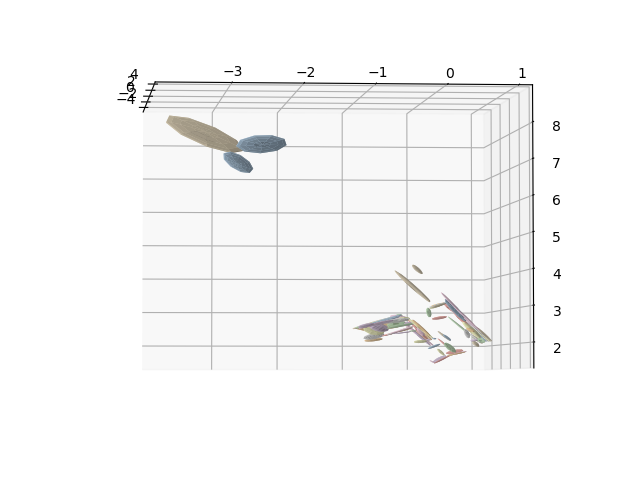

In [139]:
means,covars,weights = files[0].means_,files[0].covariances_,files[0].weights_
fig = plt.figure()
ax = Axes3D(fig)
colors = plt.cm.Pastel1(np.arange(means.shape[0])/(means.shape[0])) #plt.rcParams['axes.prop_cycle'].by_key()['color']
np.random.shuffle(colors)
for i in range(means.shape[0]):
    orig_i = i
    mean,covar = means[i],covars[i]
    u,s,vt = np.linalg.svd(covar)
    coefs = (.002, .002, .002)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
    # Radii corresponding to the coefficients:
    rx, ry, rz = 1.7*np.sqrt(s)#s#1/np.sqrt(coefs)
    
    R_reg = vt.T @ np.diag([1,1,np.linalg.det(vt.T @ u.T)]) @ u.T
    
    #print(eigs)
    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 10)
    v = np.linspace(0, np.pi, 10)

    # Cartesian coordinates that correspond to the spherical angles:
    # (this is the equation of an ellipsoid):
    x = rx * np.outer(np.cos(u), np.sin(v)) #+ mean[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) #+ mean[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) #+ mean[2]
    
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j],y[i,j],z[i,j] = np.dot([x[i,j],y[i,j],z[i,j]], vt) + mean    
    # Plot:
    res = ax.plot_surface(x,y,z,  color=colors[orig_i],shade=True,linewidth=0.0)

<IPython.core.display.Javascript object>


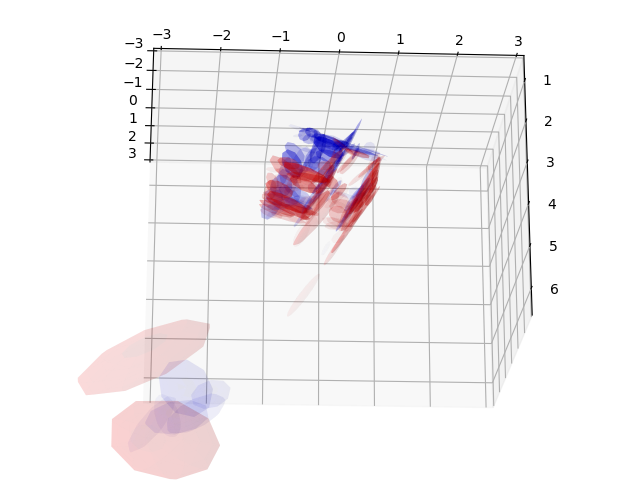

(0.5, 6.5)

In [20]:
means,covars,weights = files[10].means_,files[10].covariances_,files[10].weights_
fig = plt.figure()
ax = Axes3D(fig)
for i in range(means.shape[0]):
    orig_i = i
    mean,covar = means[i],covars[i]
    u,s,vt = np.linalg.svd(covar)
    # Radii corresponding to the coefficients:
    rx, ry, rz = 3*np.sqrt(s)#s#1/np.sqrt(coefs)
    
    R_reg = vt.T @ np.diag([1,1,np.linalg.det(vt.T @ u.T)]) @ u.T
    
    #print(eigs)
    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 10)
    v = np.linspace(0, np.pi, 10)

    # Cartesian coordinates that correspond to the spherical angles:
    # (this is the equation of an ellipsoid):
    x = rx * np.outer(np.cos(u), np.sin(v)) #+ mean[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) #+ mean[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) #+ mean[2]
    
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j],y[i,j],z[i,j] = np.dot([x[i,j],y[i,j],z[i,j]], vt) + mean    
    # Plot:
    res = ax.plot_surface(x,y,z,color='r',shade=True,linewidth=0.0,alpha=np.minimum(1.0,weights[orig_i]*10))
    
means,covars,weights = files[185].means_,files[185].covariances_,files[185].weights_
for i in range(means.shape[0]):
    orig_i = i
    mean,covar = means[i],covars[i]
    u,s,vt = np.linalg.svd(covar)
    # Radii corresponding to the coefficients:
    rx, ry, rz = 3*np.sqrt(s)#s#1/np.sqrt(coefs)
    
    R_reg = vt.T @ np.diag([1,1,np.linalg.det(vt.T @ u.T)]) @ u.T
    
    #print(eigs)
    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 10)
    v = np.linspace(0, np.pi, 10)

    # Cartesian coordinates that correspond to the spherical angles:
    # (this is the equation of an ellipsoid):
    x = rx * np.outer(np.cos(u), np.sin(v)) #+ mean[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) #+ mean[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) #+ mean[2]
    
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j],y[i,j],z[i,j] = np.dot([x[i,j],y[i,j],z[i,j]], vt) + mean    
    # Plot:
    res = ax.plot_surface(x,y,z,color='b',shade=True,linewidth=0.0,alpha=np.minimum(1.0,weights[orig_i]*10))
ax.view_init(elev=12., azim=-4)
ax.set_xlim3d(-3,3)
ax.set_ylim3d(-3,3)
ax.set_zlim3d(.5,6.5)

In [15]:
import pandas as pd
gt = pd.read_csv('rgbd_dataset_freiburg3_long_office_household-groundtruth.txt',' ',comment='#',header=None,names='timestamp tx ty tz qx qy qz qw'.split(' '))
def row_to_vec(row):
    a = np.array(row)
    return a[1:4], a[4:]
from scipy.spatial.distance import cdist, pdist
time_dists = cdist(np.array(gt.timestamp)[:,None],np.array(name_times)[:,None])
matches = time_dists.argmin(axis=0)

frm = row_to_vec(gt.iloc[matches[10]])
to = row_to_vec(gt.iloc[matches[100]])
matches[10],matches[100]

(26, 342)

In [16]:
time_dists[26,10],time_dists[630,185]

(0.004773139953613281, 0.0015530586242675781)

In [17]:
frm[1]/np.linalg.norm(frm[1]),to[1]/np.linalg.norm(to[1])

(array([-9.99979366e-05,  8.61482223e-01, -5.07489528e-01, -1.73996410e-02]),
 array([ 0.07230005,  0.85920058, -0.50040034, -0.07840005]))

In [18]:
ttrue = frm[0] - to[0]
rf =  transforms3d.quaternions.quat2mat(frm[1]/np.linalg.norm(frm[1]))
rt = transforms3d.quaternions.quat2mat(to[1]/np.linalg.norm(to[1]))

#Rtrue = transforms3d.quaternions.quat2mat(quat)
Rtrue = rt.T @ rf

<IPython.core.display.Javascript object>


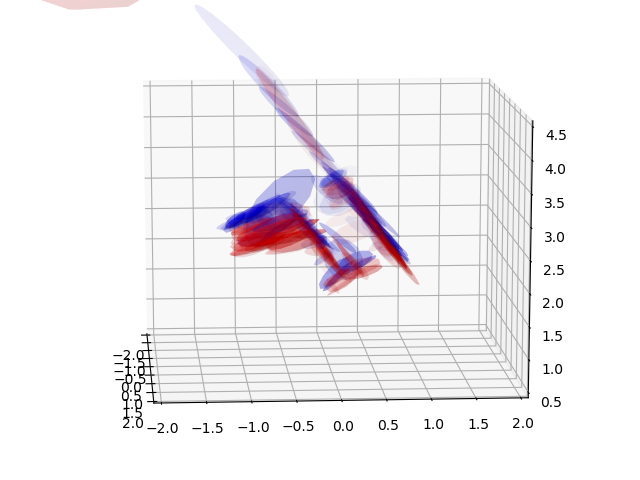

(0.5, 4.5)

In [19]:
means,covars,weights = files[10].means_,files[10].covariances_,files[10].weights_
fig = plt.figure()
ax = Axes3D(fig)
for i in range(means.shape[0]):
    orig_i = i
    mean,covar = means[i],covars[i]
    u,s,vt = np.linalg.svd(covar)
    # Radii corresponding to the coefficients:
    rx, ry, rz = 3*np.sqrt(s)#s#1/np.sqrt(coefs)
    
    R_reg = vt.T @ np.diag([1,1,np.linalg.det(vt.T @ u.T)]) @ u.T
    
    #print(eigs)
    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 12)
    v = np.linspace(0, np.pi, 12)

    # Cartesian coordinates that correspond to the spherical angles:
    # (this is the equation of an ellipsoid):
    x = rx * np.outer(np.cos(u), np.sin(v)) #+ mean[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) #+ mean[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) #+ mean[2]
    
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j],y[i,j],z[i,j] = np.dot([x[i,j],y[i,j],z[i,j]], vt) + mean    
    # Plot:
    res = ax.plot_surface(x,y,z,color='r',shade=True,linewidth=0.0,alpha=np.minimum(1.0,weights[orig_i]*10))
    
means,covars,weights = files[100].means_,files[100].covariances_,files[100].weights_
for i in range(means.shape[0]):
    orig_i = i
    mean,covar = means[i]+ttrue, covars[i] @ Rtrue.T
    u,s,vt = np.linalg.svd(covar)
    # Radii corresponding to the coefficients:
    rx, ry, rz = 3*np.sqrt(s)#s#1/np.sqrt(coefs)
    
    R_reg = vt.T @ np.diag([1,1,np.linalg.det(vt.T @ u.T)]) @ u.T
    
    #print(eigs)
    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 12)
    v = np.linspace(0, np.pi, 12)

    # Cartesian coordinates that correspond to the spherical angles:
    # (this is the equation of an ellipsoid):
    x = rx * np.outer(np.cos(u), np.sin(v)) #+ mean[0]
    y = ry * np.outer(np.sin(u), np.sin(v)) #+ mean[1]
    z = rz * np.outer(np.ones_like(u), np.cos(v)) #+ mean[2]
    
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j],y[i,j],z[i,j] = np.dot([x[i,j],y[i,j],z[i,j]], vt) + mean    
    # Plot:
    res = ax.plot_surface(x,y,z,color='b',shade=True,linewidth=0.0,alpha=np.minimum(1.0,weights[orig_i]*10))
ax.view_init(elev=12., azim=-4)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(.5,4.5)